In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings

import torch

# only show 5 elements of a tensor
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=5)
torch.manual_seed(0)
warnings.filterwarnings("ignore")

!rm -rf lightning_logs

# Training a model

`graph-pes` aims to make getting set up with a new project as simple as possible. Below, we train a simple `LennardJones` for copper.

## 1: Data

`GraphPESModels` act on structures represented as `AtomicGraphs`. We expose several functions to make loading this data as simple as possible.

First, we load some chemical data. Here we use the wonderful [load-atoms](https://jla-gardner.github.io/load-atoms/) package to load a dataset of `ase.Atoms` objects:


In [2]:
from load_atoms import load_dataset

structures = load_dataset("Cu-POET.extxyz")
structures

Dataset:
    structures: 163
    atoms: 5,051
    species:
        Cu: 100.00%
    properties:
        per atom: (forces)
        per structure: (config_type, energy, stress)

We can see that this dataset has 163 structures, for a total of 5,051 atoms. Conveniently, we can see that the structures are labelled with per-structure energies (together with forces and stresses, which we will ignore for now).
Inspecting the first structure in this dataset gives:


In [3]:
structures[0]

Atoms(symbols='Cu8', pbc=True, cell=[2.5674848, 2.5674848, 25.41680279], forces=..., calculator=SinglePointCalculator(...))

Once we have a dataset of `ase.Atoms` objects, we can convert them to `AtomicGraphs` using the `convert_to_atomic_graphs` function. Using a cutoff of 5.0 Å, we can see that the first structure has 292 edges:


In [4]:
from graph_pes.data.io import to_atomic_graphs

graphs = to_atomic_graphs(structures, cutoff=5.0)
graphs[0]

AtomicGraph(atoms: 8, edges: 292, has_cell: True, labels: ['energy', 'forces', 'stress'])

## 2: Model

Orthogonal to our data setup, we also need to define a model. Here we choose the simple `LennardJones` pair potential. Many others are available.


In [5]:
from graph_pes.models.zoo import LearnableOffset, LennardJones

model = LearnableOffset() + LennardJones()
model

AdditionModel(
  LearnableOffset(trainable=True),
  LennardJones(epsilon=0.1, sigma=1.0)
)

## 3: Training

Now we can train the model on our data. Since `GraphPESModel`'s are just normal `torch.nn.Module`'s, we can standard PyTorch training setups.

For convenience, `graph-pes` exposes a `train_model` function that takes care of much of the boilerplate, and uses `pytorch-lightning` under-the-hood to make the analysis of training runs easy.


In [6]:
import torch
from graph_pes.data.utils import random_split
from graph_pes.training import Adam, train_model
from graph_pes.training.loss import RMSE, Loss

# define a train/val/test split
train, val, test = random_split(graphs, [120, 20, 23], seed=42)

train_model(
    model,
    train,
    val,
    optimizer=Adam(lr=1e-2),
    # only train the model on the energy property
    loss=Loss("energy", RMSE()),
    batch_size=32,
    # the arguments below are passed to the PyTorch Lightning Trainer:
    max_epochs=50,
    accelerator="cpu",
)

24-06-09 09:16:29 - graph-pes - INFO: Getting ready to train the model...
24-06-09 09:16:29 - graph-pes - INFO: 
         Number of learnable params:
             LearnableOffset: 0
             LennardJones   : 2
24-06-09 09:16:29 - graph-pes - INFO: 
         TotalLoss:
             (weight) : (loss)
                  1.0 : Loss("energy", metric=RMSE(), name="energy/rmse")
24-06-09 09:16:29 - graph-pes - INFO: Pre-fitting the model...
24-06-09 09:16:29 - graph-pes - WARNING: 
         Estimated per-element energy offsets from the training data:
             PerElementParameter({'Cu': -3.53}, trainable=True)
         This will lead to a lack of guaranteed physicality in the model, 
         since the energy of an isolated atom (and hence the behaviour of 
         this model in the dissociation limit) is not guaranteed to be 
         correct. Use a FixedOffset energy offset model if you require
         and know the reference energy offsets.
24-06-09 09:16:29 - graph-pes - INFO: Hand

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin


Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


## 4: Analysis

How did our model do? `graph-pes` exposes several useful functions for analysis:

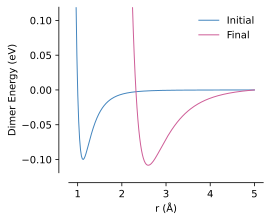

In [7]:
import matplotlib.pyplot as plt
from graph_pes.analysis import dimer_curve

# what we started with
_reference_model = LennardJones()
dimer_curve(_reference_model, "Cu", units="eV", label="Initial", c="C0")

# vs. what we trained
dimer_curve(model, "Cu", units="eV", label="Final", c="C1")

plt.xlim(left=0.8)
plt.legend(loc="upper right");

By default, `dimer-curve` zeros the energy at ``rmax``. We can also see that 
the model has learned a per-atom energy shift:

In [8]:
from ase import Atoms
from graph_pes.data.io import to_atomic_graph

isolated = to_atomic_graph(Atoms("Cu"), 1.0)

with torch.no_grad():
    print(f"Initial : {_reference_model(isolated).item():5.2f} eV")
    print(f"Final   : {model(isolated).item():5.2f} eV")

Initial :  0.00 eV
Final   : -2.87 eV


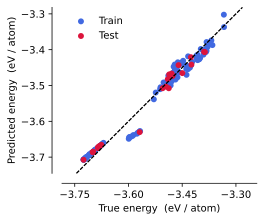

In [9]:
from graph_pes.analysis import parity_plot
from graph_pes.transform import DividePerAtom

for name, data, colour in zip(
    ["Train", "Test"],
    [train, test],
    ["royalblue", "crimson"],
):
    parity_plot(
        model,
        data,
        transform=DividePerAtom(),
        units="eV / atom",
        label=name,
        c=colour,
    )

plt.legend(fancybox=False, loc="upper left");

Since our model is fully differentiable, we can use the inbuilt `torch.autograd` machinery to compute forces as the negative gradient of the energy with respect to atomic positions.

In [10]:
structure = test[0]
structure["_positions"].requires_grad = True
energy = model(test[0])
forces = -torch.autograd.grad(energy, test[0]["_positions"])[0]
structure["_positions"].requires_grad = False

energy, forces.shape

(tensor(-117.910, grad_fn=<SumBackward1>), torch.Size([32, 3]))

`graph-pes` makes this easy to do via the :func:`~graph_pes.get_predictions` function:

In [11]:
from graph_pes import get_predictions

# get predictions for all of the test set, using torch.autograd 
# internally to get the forces and stresses
predictions = get_predictions(model, test)
{key: value.shape for key, value in predictions.items()}

{'energy': torch.Size([23]),
 'forces': torch.Size([714, 3]),
 'stress': torch.Size([23, 3, 3])}

Despite only training on energies, we can test on force errors:

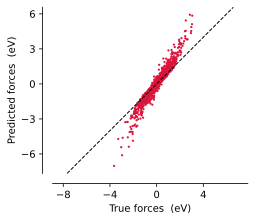

In [12]:
parity_plot(model, test, property="forces", units="eV", c="crimson", s=5)

And that's a wrap! We've trained a simple model on a simple dataset. See other examples for more advanced use-cases.
